# Getting the Computer to Win: Quantifying Ambiguous Literary Devices Using Stories in Katherine Mansfield's _The Garden Party and Other Stories_

## Zoe Husted
August 15, 2020

Introduction to Computational Literary Analysis

UC Berkeley, Summer 2020

Instructor: Jonathan Reeve

## Introduction

A total of 15 stories in the collection, Katherine Mansfield's _The Garden Party and Other Stories_ covers topics like privilege, death, family, and more in the span of just a couple thousand words each. She is able to evoke a variety of emotions over the course of each story, despite the short lengths. As with many short story collections, the stories are linked through not only recurring characters, but also through common themes, motifs, and atmospheres. Computational analysis has evolved significantly, being able to make connections that wouldn't be caught by a regular read through. On the other hand, when we as humans read each story, we have the advantage of our brain doing the work for us of extracting themes and understanding sentiment, but it takes more work to analyze the same things computationally. In this analysis, I will use the stories within _The Garden Party_ collection to exmplify the different ways that computational analysis can work with and without literary context to extract some of the more ambigous literary devices, like theme and tone. Comparisons can be made on many different levels, so I chose to analyze broadly using PCA and then dive into the stories on a more individual level and compare the average sentiement over the course of each story, finishing up with another broad look at the themes in the story based on counting words that fall into specific entity groups for all of the stories.

## Imports

In [1]:
import nltk
import pandas as pd
import requests
import json
import numpy as np
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer, SentimentAnalyzer
import matplotlib.pyplot as plt

## Materials

The text used for this analysis will be the complete collection of 15 short stories from Katherine Manfield's _The Garden Party and Other Stories_. 

It includes the following stories:
1. At the Bay
2. The Garden Party
3. The Daughters of the Late Colonel
4. Mr. and Mrs. Dove
5. The Young Girl
6. Life of Ma Parker
7. Marriage a La Mode
8. The Voyage
9. Miss Brill
10. Her First Ball
11. The Singing Lesson
12. The Stranger
13. Bank Holiday
14. An Ideal Family
15. The Lady’s Maid

In [2]:
gardenParty = json.loads(requests.get('http://corpus-db.org/api/id/1429.0/fulltext').text)[0]

In [3]:
gardenPartyText = gardenParty['text']
gardenPartyStories = gardenPartyText.split("\n\n\n\n\n")[2:-1]

In [4]:
# An untouched and lowered version of the text, each useful for different analyses
gardenPartyCorpus = {title[3:-1].lower(): text for title, text in [story.split("\n\n", maxsplit=1) for story in gardenPartyStories]}
gardenPartyCorpusLower = {title[3:-1].lower(): text.lower() for title, text in [story.split("\n\n", maxsplit=1) for story in gardenPartyStories]}

## When the Computer Knows More: PCA Analysis

When looking at broad overarching similarities between any text, PCA is a good way to get a sense of which stories are computationally similar in multiple dimensions. The math done behind the scenes during PCA is more of a black box and leaves us to make some assumptions to the similarities that show up. This process includes vectorizing the text in each story and fitting it to a PCA with two components, which makes it easier to graph.

### Process

In [5]:
tfidfVectorizer = TfidfVectorizer(max_features=400)

In [6]:
allText = []
for text in gardenPartyCorpusLower.values():
    allText += [text]

In [7]:
textMatrix = tfidfVectorizer.fit_transform(allText).todense()

In [8]:
pca = PCA(n_components=2)

In [9]:
textPoints = pca.fit_transform(textMatrix)

In [10]:
gardenPartyDf = pd.DataFrame(textPoints, index=gardenPartyCorpus.keys(), columns=["X", "Y"])

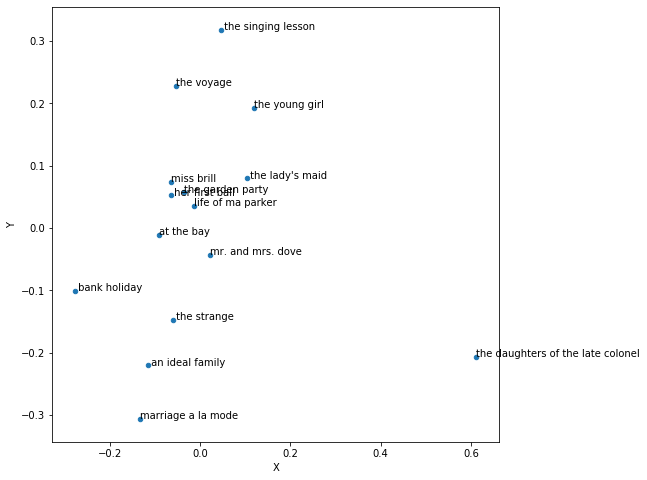

In [11]:
ax = gardenPartyDf.plot(kind='scatter', x='X', y='Y', figsize=(8,8))
for title, points in gardenPartyDf.iterrows():
    ax.annotate(title, points)

### Discussion

The scatter plot shows one main cluster of stories that are shown to be pretty similar, these stories being "Miss Brill", "The Garden Party", "Life of Ma Parker", and "Her First Ball". Because "The Garden Party" and "Her First Ball" have overlapping characters, I expected them to be grouped together, but "Miss Brill" and "Life of Ma Parker" are also just as close despite the entirely different set of characters. From the context of the stories, I could imagine that these five stories are grouped together potentially because they all feature a third person female main character narration, although that is also a feature in "The Singing Lesson" and "The Voyage", but because PCA analyzes all of the words and just does its best to compress similarities into two dimensions, the narration style could be one aspect of similarity on top of many other aspects. Another note on the distribution of the plot is that most of the stories sit relatively close to 0.0 on the X axis, and most going into the -X range, the most obvious exception being "The Daugters of the Late Colonel" which sits very far in the +X direction. "The Daughters of the Late Colonel" touches on many of the same themes as the other stories, like death and family, but is being classified as very distince from all of the other stories. It is difficult to pinpoint exact differences that make this story an outlier, but it is good to keep in mind when going through other analyses. As mentioned before, PCA is a great example of the computational methods being able to to perform more complex analyses whose reasonings can not be immediately pinpointed, even with the context of every story. Overall, PCA does a good job at determining why some stories are similar in ways that we as humans may be unable to and it points us in the right direction when looking at all the stories on a more individual level, to see if futher analyses can be linked back to the data provided from PCA as a way to gain some insight into the computer's methods.

 ## Computational & Contextual Compromise: Mapping Sentiment Analysis Over the Course of Each Story

Sentiment analysis and tone in text is something that both humans and computers can pick up on relatively well, although there are some instances where computers aren't able to pick up on slang or sarcasm, so it still isn't perfect. In the following code I analyze the average sentiment over the progression of each narrative, averaging out the smoothing based on how long the story is.  

In [12]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Zoe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
sentimentAnalyzer = SentimentIntensityAnalyzer()

def getSentiment(text): 
    return sentimentAnalyzer.polarity_scores(text)['compound']    

In [14]:
gardenPartySentences = {title: [sentence for sentence in nltk.sent_tokenize(gardenPartyCorpus[title])] for title in gardenPartyCorpus.keys()}
gardenPartySentiments = pd.DataFrame([[getSentiment(sentence) for sentence in gardenPartySentences[title]] for title in gardenPartyCorpus.keys()], index=gardenPartyCorpus.keys())

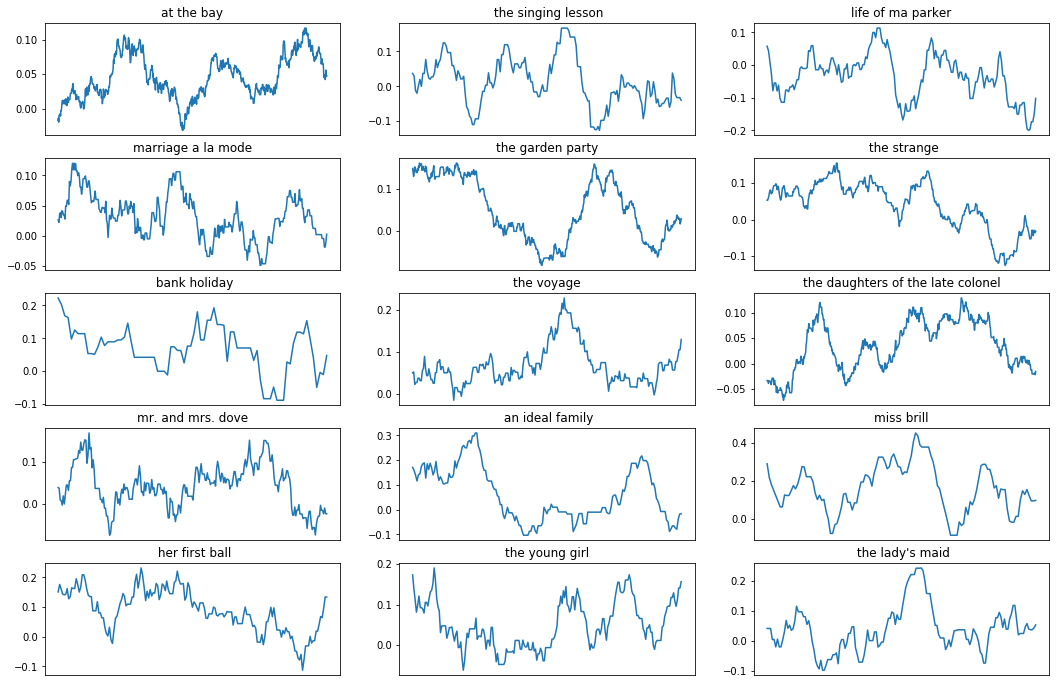

In [15]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(18, 12)

for i in range(len(gardenPartySentences.keys())):
    axs[i%5, i%3].set_title(gardenPartySentiments.index[i])
    axs[i%5, i%3].plot(gardenPartySentiments.iloc[i].rolling(len(gardenPartySentiments.iloc[i].dropna())//10, center=True).mean(), figure=fig)
    
for ax in axs.flat:
    ax.axes.xaxis.set_visible(False)

### Discussion

Laying out the sentiment for each plot, we can start to see some similar themes. A majority of the stories end on a more negative note than they begin with, which is something we can even recognize just from the stories we read in class. "The Garden Party" begins with an exciting afternoon of party planning, but ends with Laura visiting the widow of the man that died in their neighboring town. This is seen in the way that as the story progresses the sentiment becomes more negative (the news of the dead man) then positive again (the actual garden party) and back down to negative (Laura visiting the dead man). Looking back at the stories that were similar from the PCA analysis, "The Garden Party", "Her First Ball", "Life of Ma Parker", and "Miss Brill" all begen relatively positively, but take a negative turn towards the second half of the story, and start becoming more positive again by the very end. We can see a similarity in the tone of these stories which may play into why they were grouped together in the PCA analysis. In general, most of the stories are neither all positive nor all negative, and tend to have significant peaks in positive sentiment followed by steep drops back into negative terratory. I think this speaks to the range of emotions that Mansfield is able to convey in each small story, she can quickly transition from excitement to somberness in the span of a few sentences making each story a unique ride for the reader. While someone reading the story may have a better grasp at the immediate sentiment of the line(s) they are reading, computationally mapping all of the sentiments over the course of any story can give a more full picture of the tone throughout the plot. This is a great example of how computation and context work hand in hand to extract deeper meaning from texts.

## Context Required: Quantifying Common Themes Across Stories

The final area I decided to analyze was common motifs and themes across the different stories, which is particularly challinging to approach computationally. My first thought was that there must be some words that appear much more commonly than others, so I could just count those. However, when I tried to collect common words I kept coming up with words without much meaning on an individual level, even when I tried to filter out articles and prepositions. I realized what I was really looking for was the common categories that the words fell into. So I decided to use wordnet to instead categorize words based on their hypernyms. I ended up evaluating the stories as one single collection of text and looked for hypernyms at only a depth of three to spread the widest net. This meant looking for the hyponyms of "physical entities" and "abstract entities" and then sorting them into their respective category.

In [16]:
gardenPartyLowerTokens = {title: nltk.word_tokenize(gardenPartyCorpusLower[title]) for title in gardenPartyCorpusLower.keys()}
gardenPartyLowerAlphaTokens = {title: [token for token in gardenPartyLowerTokens[title] if token.isalpha()] for title in gardenPartyLowerTokens.keys()}

In [17]:
physical_entity = wn.synsets("physical_entity")[0]
abstract_entity = wn.synsets("abstract_entity")[0]

entities = {}

physical_entities = {}
for hyponym in physical_entity.hyponyms():
    physical_entities[hyponym] = 0
entities["physical"] = physical_entities

abstract_entities = {}
for hyponym in abstract_entity.hyponyms():
    abstract_entities[hyponym] = 0
entities["abstract"] = abstract_entities

# This needs to remain in the same cell as when entities is initialized, otherwise it will keep doubling the count every time it is called
for title in gardenPartyLowerAlphaTokens.keys():
    for token in gardenPartyLowerAlphaTokens[title]:
        synsets = wn.synsets(token)
        for synset in synsets:
            # Not every word has hypernyms so we have to check that hypernyms exist
            if len(synset.hypernyms()) > 0:
                minDepth = synset.min_depth()
                hypernym = synset.hypernyms()[0]
                for i in range(minDepth-3):
                    # Words that have some hypernyms may not extend all the way up to physical or abstract entities
                    if len(hypernym.hypernyms()) == 0:
                        break
                    hypernym = hypernym.hypernyms()[0]
                if hypernym in entities['physical'].keys():
                    entities['physical'][hypernym] += 1
                elif hypernym in entities['abstract'].keys():
                    entities['abstract'][hypernym] += 1

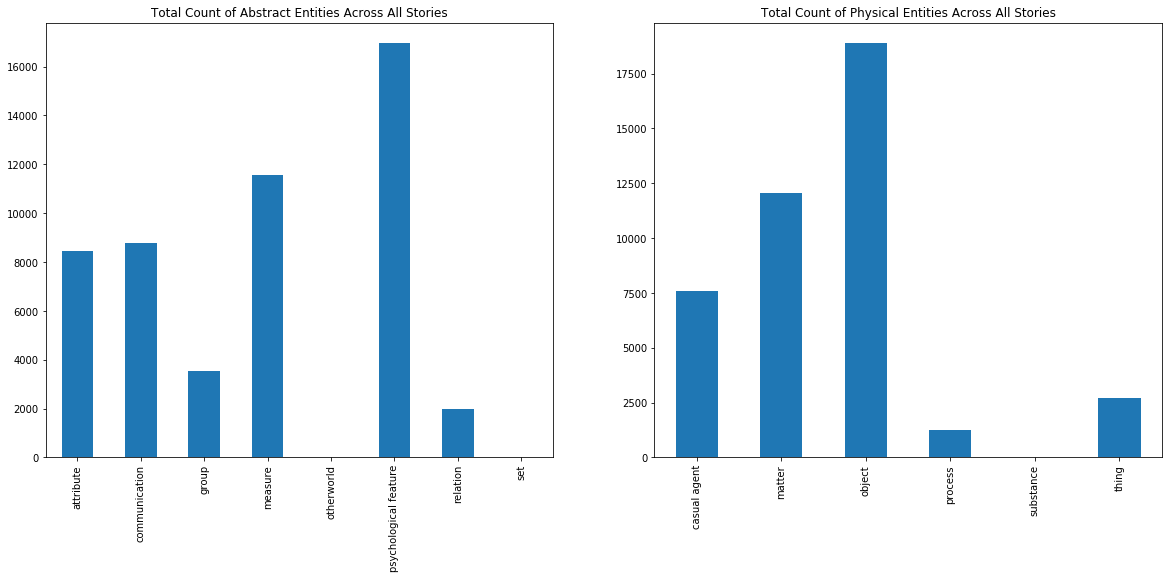

In [18]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

# Plotting abstract entities
abstractLabels = ['attribute', 'communication', 'group', 'measure', 'otherworld', 'psychological feature', 'relation', 'set']
pd.Series(entities['abstract']).plot(kind="bar", ax=ax[0])
ax[0].set_xticklabels(abstractLabels)
ax[0].set_title("Total Count of Abstract Entities Across All Stories")

# Plotting physical entities
physicalLabels = ['casual agent', 'matter', 'object', 'process', 'substance', 'thing']
pd.Series(entities['physical']).plot(kind="bar", ax=ax[1])
ax[1].set_xticklabels(physicalLabels)
ax[1].set_title("Total Count of Physical Entities Across All Stories")

plt.show()

In [19]:
print("Total abstract entities: ", sum(entities['abstract'].values()))
print("Total physical entities: ", sum(entities['physical'].values()))

Total abstract entities:  51271
Total physical entities:  42464


### Entity Descriptions

#### Abstract entities - a general concept formed by extracting common features from specific examples
- **attribute**: an abstraction belonging to or characteristic of an entity
- **communication**: something that is communicated by or to or between people or groups
- **group**: any number of entities (members) considered as a unit
- **measure**: how much there is or how many there are of something that you can quantify
- **otherworld**: an abstract spiritual world beyond earthly reality
- **psychological feature**: a feature of the mental life of a living organism
- **relation**: an abstraction belonging to or characteristic of two entities or parts together
- **set**: an abstract collection of numbers or symbols

#### Physical entities - an entity that has physical existence
- **causal agent**: any entity that produces an effect or is responsible for events or results
- **matter**: that which has mass and occupies space
- **object**: a tangible and visible entity; an entity that can cast a shadow
- **process**: a sustained phenomenon or one marked by gradual changes through a series of states
- **substance**: material of a particular kind or constitution
- **thing**: a separate and self-contained entity

### Discussion

Looking at the split between physical and abstract entities is a good way to grasp how the stories are grounded in tangible words versus less tangible concepts. From the graphs we see that objects are the most popular physical entity, which makes sense considering how objects can be used not only to create an atmosphere in settings, but also as symbols, like the fruit that the father brings home in "Marriage A La Mode". On the other hand, psychological features are the most popular abstract entity, which can mean anything from cognitive thoughts to events (of which there are many throughout these stories). Overall though, there are more abstract entities in the stories combined than physical entities, which makes sense for Mansfield's writing. Emotions, dialogue, and group dynamics are major themes across all of her stories, as seen by the counts for the psychological features, communication, and group categories. I think that mapping the text to such broad categories has allowed us to quantify themes in a way that is better than individually counting words. This analysis would not be nearly as complete without the context of the stories however, especially with such broad categories. Potentially narrowing the scope of the groups by one or more levels of hyponyms could provide more useful information without the need for much context, but this would also require filtering out categories with less words to pick up on only the more popular themes.

## Conclusion

Mimicking the human brain is a goal that computation has succeeded and struggled in in many areas. The goal of this analysis was to be able to quantify less tangible concepts like emotion and themes through computational methods, which I approached through the lens of PCA, sentiment analysis, and wordnet categorization. PCA offers a starting point by grouping stories the algorithm deems similar, although it is done in a complex way such that we are not able ot actually know what links the stories together. However, it does allow a baseline on which to analyze the stories from different perspectives. Processing tone in a story is the next area I tackled, which can be done through sentiment analysis, but which is also not perfect at detecting sentiment every time. On the whole, sentiment analysis can show us similar arcs in tone across the different stories, and information from the PCA grouping can be taken into account for deeper analysis. Finally, analyzing themes is something our brain pull from many different areas to do, making it more difficult to to computationally. Ultimately, by tracing the hypernyms of words to generic enough categories can display common themes present over the entire story colleciton as a whole. Computational analysis can range from analyzing text so technically that we don't have the context to understand the background of the analysis (PCA), to requiring context to understand the meaning of analysis (connecting word categories to themes). Ultimately, multiple tools can be used to approach analysis and this project showed the range of some of those tools.